#Environment configuration

Install packages.

In [ ]:
#Don't run this code unless you really want to install the packages.
#!pip install alive-progress -q
#!pip install optuna -q

     |████████████████████████████████| 80 kB 7.1 MB/s 
     |████████████████████████████████| 207 kB 52.1 MB/s 
     |████████████████████████████████| 348 kB 7.1 MB/s 
     |████████████████████████████████| 209 kB 55.2 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 112 kB 33.9 MB/s 
     |████████████████████████████████| 147 kB 7.1 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 


Import packages.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

import optuna
from optuna.trial import TrialState

import numpy as np
import os
import math
import argparse
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools
import shutil

from google.colab import drive
from alive_progress import alive_bar
from tabulate import tabulate
import time

Mount and config GDrive & paths.

In [ ]:
drive.mount('/content/drive')
gdrive = '/content/drive/My Drive/ml_projects/STRHANGE/'

keypoints_path = gdrive + '/data/JESTER/extracted/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


# Experiment configuration

In [ ]:
N_WAY = 5
K_SHOT = 2

# Set up functions and classes

This section contains all functions and classes that are important for the remainder of this notebook. An explanation of the functions and their parameters & outputs can be found in the function headers.

#### Model training

In [ ]:
def run_training(task_param, input_param, model_param, training_param):
  """
  Training Function - performs a single model training for a set of parameters
  Args:
    task_param (dict): task-related parameters
    input_param (dict): input-related parameters
    model_param (dict): model-related parameters
    training_param (dict): training-related paramaters
  Returns:
    logging (pd.dataframe): dataframe with user configurated logging information on the training-history
  """

  ### PARAMETER UNPACKING AND INITIALIZATION ###
  print('Initializing training...\n')

  #task-parameters
  SUPPORT_NUM_PER_CLASS = task_param['support_num_per_class'] 
  QUERY_NUM_PER_CLASS = task_param['query_num_per_class']  
  NUM_CLASSES = task_param['num_classes']  

  #input-parameters
  SEQUENCE_LENGTH = input_param['sequence_length']
  FEATURE_LENGTH = input_param['feature_length'] 

  #model-parameters
  NUM_LSTM_LAYER_ENCODER = model_param['num_lstm_layer_encoder']
  NUM_UNITS_LSTM_ENCODER = model_param['num_units_lstm_encoder']
  NUM_LSTM_LAYER_RELATIONNET = model_param['num_lstm_layer_relationnet']
  NUM_UNITS_LSTM_RELATIONNET = model_param['num_units_lstm_relationnet']
  NUM_UNITS_FC_RELU = model_param['num_units_fc_relu']

  #training-parameters
  LEARNING_RATE = training_param['learning_rate']
  LEARNING_RATE_SCHEDULE_RATE = training_param['learning_rate_schedule_rate']
  NUM_TRAIN_EPISODES = training_param['num_train_episodes']
  UPDATE_AND_EVAL_RATE = training_param['update_and_eval_rate']
  NUM_EVAL_EPISODES = training_param['num_eval_episodes']
  SAVE_PATH = training_param['save_path']
  SAVE_LOGGING = training_param['save_logging']
  SAVE_ALL = training_param['save_all']
  SAVE_BEST = training_param['save_best']
  TUNING_RUN = training_param['tuning_run']
  trial = training_param['trial']

  if NUM_TRAIN_EPISODES % UPDATE_AND_EVAL_RATE != 0:
    raise ValueError(f'Invalid Parameters: UPDATE_AND_EVAL_RATE must be a multiple of NUM_TRAIN_EPISODES.')

  print('  Parameters accepted and set.')

  ### MODEL INITIALIZATION ###
  feature_encoder = LSTMEncoder(FEATURE_LENGTH, NUM_UNITS_LSTM_ENCODER, NUM_LSTM_LAYER_ENCODER).to(device)
  print('  Feature encoder intialized, initial weights set.')
  relation_network = RelationNetwork(NUM_UNITS_LSTM_ENCODER*2, NUM_UNITS_LSTM_RELATIONNET, NUM_UNITS_FC_RELU, NUM_LSTM_LAYER_RELATIONNET).to(device) 
  print('  Relation network intialized, initial weights set.')

  feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(),lr=LEARNING_RATE)
  feature_encoder_scheduler = StepLR(feature_encoder_optim,step_size=LEARNING_RATE_SCHEDULE_RATE,gamma=0.5) 

  relation_network_optim = torch.optim.Adam(relation_network.parameters(),lr=LEARNING_RATE)
  relation_network_scheduler = StepLR(relation_network_optim,step_size=LEARNING_RATE_SCHEDULE_RATE,gamma=0.5) 

  mse = nn.MSELoss().to(device)

  print('  Optimizer & Learning Rate Scheduler initalized.')

  ### SET UP LOGGING ###

  # Create logging dir for current run
  logging = []
  if SAVE_LOGGING == True or SAVE_ALL == True or SAVE_BEST == True:

    if not os.path.exists(SAVE_PATH):
      os.makedirs(SAVE_PATH)

    run = 0
    run_list = os.listdir(SAVE_PATH)

    for i in range(len(run_list)):
      try:
        run_list[i] = int(run_list[i].split('_')[1])
      except:
        next

    run_list = [num for num in run_list if isinstance(num, (int,float))]

    if run_list:
      run = int(max(run_list)) + 1
    log_dir = os.path.join(SAVE_PATH, 'run_' + str(run))

    if not os.path.exists(log_dir):
      os.makedirs(log_dir)

    #Log params to logging dir
    with open(log_dir + '/task_param.pkl', 'wb') as f:
      pickle.dump(task_param, f)

    with open(log_dir + '/input_param.pkl', 'wb') as f:
      pickle.dump(input_param, f)      

    with open(log_dir + '/model_param.pkl', 'wb') as f:
      pickle.dump(model_param, f)

    with open(log_dir + '/training_param.pkl', 'wb') as f:
      pickle.dump(training_param, f)
  
  print(f'  Created logging folder: {log_dir}')

  print('\nTraining initalized. \n\n')

  print('Start training...\n')

  ### TRAINING ###

  #loop over number of episodes
  for episode in range(int(NUM_TRAIN_EPISODES/UPDATE_AND_EVAL_RATE)):

    print(f'Episode: {episode*UPDATE_AND_EVAL_RATE}/{NUM_TRAIN_EPISODES} to {(episode + 1) * UPDATE_AND_EVAL_RATE}/{NUM_TRAIN_EPISODES}')

    step_train_accuracy = 0
    step_train_loss = 0

    with alive_bar(UPDATE_AND_EVAL_RATE, title=f'  Training...', force_tty = True) as bar:
      for i in range(UPDATE_AND_EVAL_RATE):
        # Generate task and get data
        query_x, query_y, support_x, support_y = gen_task(n_way = NUM_CLASSES, n_support = SUPPORT_NUM_PER_CLASS, n_query = QUERY_NUM_PER_CLASS, data_x = X, data_y = y, split = 'train')
        query_x, query_y, support_x, support_y = query_x.to(device), query_y.to(device), support_x.to(device), support_y.to(device)
          
        # Predict
        relations, query_y_one_hot = predict(feature_encoder, relation_network, support_x, query_x, query_y, NUM_CLASSES, SUPPORT_NUM_PER_CLASS, QUERY_NUM_PER_CLASS, SEQUENCE_LENGTH, NUM_UNITS_LSTM_ENCODER)

        # Calculate loss         
        loss = mse(relations,query_y_one_hot)
        step_train_loss += loss.item()

        # Calculate accuracy 
        _,predict_labels = torch.max(relations.data,1)
        rewards = [1 if predict_labels[j]==query_y[j] else 0 for j in range(NUM_CLASSES*QUERY_NUM_PER_CLASS)]
        accuracy = np.sum(rewards)/1.0/NUM_CLASSES/QUERY_NUM_PER_CLASS
        step_train_accuracy += accuracy

        #backpropagation - adjust the model's parameter
        feature_encoder.zero_grad()
        relation_network.zero_grad()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(feature_encoder.parameters(),0.5)
        torch.nn.utils.clip_grad_norm_(relation_network.parameters(),0.5)

        feature_encoder_optim.step()
        relation_network_optim.step()

        #update status bar
        bar()

    # print loss and acc for episode
    step_train_loss = step_train_loss/UPDATE_AND_EVAL_RATE
    step_train_accuracy = step_train_accuracy/UPDATE_AND_EVAL_RATE

    print(f'    Loss: {step_train_loss:.5f}')
    print(f'    Accuracy: {step_train_accuracy:.5f}')

    # start validation
    with torch.no_grad():

      step_eval_loss = 0
      step_eval_accuracy = 0
      best_eval_accuracy = 0

      for i in range(NUM_EVAL_EPISODES):

        # Generate task and get data
        query_x, query_y, support_x, support_y = gen_task(n_way = NUM_CLASSES, n_support = SUPPORT_NUM_PER_CLASS, n_query = QUERY_NUM_PER_CLASS, data_x = X, data_y = y, split = 'eval')
        query_x, query_y, support_x, support_y = query_x.to(device), query_y.to(device), support_x.to(device), support_y.to(device)

        # Predict
        relations, query_y_one_hot = predict(feature_encoder, relation_network, support_x, query_x, query_y, NUM_CLASSES, SUPPORT_NUM_PER_CLASS, QUERY_NUM_PER_CLASS, SEQUENCE_LENGTH, NUM_UNITS_LSTM_ENCODER)

        # Calculate loss             
        loss = mse(relations,query_y_one_hot)
        step_eval_loss += loss.item()

        # Calculate rewards for accuracy 
        _,predict_labels = torch.max(relations.data,1)
        rewards = [1 if predict_labels[j]==query_y[j] else 0 for j in range(NUM_CLASSES*QUERY_NUM_PER_CLASS)]
        step_eval_accuracy += np.sum(rewards)

      # Calculate and print loss / acc for validation-run
      step_eval_loss = step_eval_loss / NUM_EVAL_EPISODES
      step_eval_accuracy = step_eval_accuracy/1.0/NUM_CLASSES/QUERY_NUM_PER_CLASS/NUM_EVAL_EPISODES

      logging.append([step_train_loss, step_train_accuracy, step_eval_loss, step_eval_accuracy])

      print(f'  Validation with {NUM_EVAL_EPISODES} Evaluation-Episodes. Accuracy: {step_eval_accuracy:.5f}, Loss: {step_eval_loss:.5f}\n' )

      # Report results to optuna-tuning
      if TUNING_RUN == True:
        trial.report(step_eval_loss, episode * UPDATE_AND_EVAL_RATE)

        # Prune trial and save logging if loss-decrease is not promising
        if trial.should_prune():
          if SAVE_LOGGING == True:
            logging = pd.DataFrame(logging, columns=['train_loss', 'train_accuracy', 'eval_loss', 'eval_accuracy'])
            logging.eval_loss.iloc[0] = logging.train_loss.iloc[0]
            logging.eval_accuracy.iloc[0] = logging.train_accuracy.iloc[0]
            logging.to_pickle(log_dir + '/logging.pkl')
          raise optuna.exceptions.TrialPruned()

      # Save network 
      if (SAVE_BEST == True or SAVE_ALL == True) and not os.path.exists(os.path.join(log_dir, 'models')):
        os.makedirs(os.path.join(log_dir, 'models'))

      if SAVE_BEST == True and step_eval_accuracy > best_eval_accuracy:
        torch.save(feature_encoder.state_dict(),str(log_dir + '/models/feature_encoder_best.pkl'))
        torch.save(relation_network.state_dict(),str(log_dir + '/models/relation_network_best.pkl'))

      if SAVE_ALL == True:
        torch.save(feature_encoder.state_dict(),str(log_dir + '/models/feature_encoder_e' + str(episode*UPDATE_AND_EVAL_RATE) + '.pkl'))
        torch.save(relation_network.state_dict(),str(log_dir + '/models/relation_network_e' + str(episode*UPDATE_AND_EVAL_RATE) + '.pkl'))

  # Save logging
  if SAVE_LOGGING == True:
    logging = pd.DataFrame(logging, columns=['train_loss', 'train_accuracy', 'eval_loss', 'eval_accuracy'])
    logging.eval_loss.iloc[0] = logging.train_loss.iloc[0]
    logging.eval_accuracy.iloc[0] = logging.train_accuracy.iloc[0]

    logging.to_pickle(log_dir + '/logging.pkl')

  return logging

#### Hyperparameter tuning

In [ ]:
def run_tuning(trial):
  """
  Tuning Function - performs multiple model trainings and optimizes hyperparameters
  Args:
    trial (optunia-trial-object): current trial object of the optuna tuning process
  Returns:
    min_eval_loss (float): minimal loss on evaluation set
  """

  # Caution: some parameters have to be set manually to match the given task, input and training specifications
  # (this has to be done within this function, because optuna does not support additional args)

  # Set tuning parameters  
  task_param = {'support_num_per_class': K_SHOT,
                'query_num_per_class': 16,
                'num_classes': N_WAY}

  # Set input parameters  
  input_param = {'sequence_length': 72,
                 'feature_length': 63}

  # Set model parameters (suggestions by optuna)
  num_fc_layers = trial.suggest_int("num_fc_layers", 1, 3, step = 1)
  num_units_fc_relu = []
  for i in range(num_fc_layers):
    num_units = trial.suggest_categorical("num_units_fc_layer{}".format(i), [16, 32, 64, 128, 256])
    num_units_fc_relu.append(num_units)

  model_param = {'num_lstm_layer_encoder': trial.suggest_int("num_lstm_layer_encoder", 1, 3, step=1),
                 'num_units_lstm_encoder': trial.suggest_categorical("num_units_lstm_encoder", [16, 32, 64, 128, 256]),
                 'num_lstm_layer_relationnet': trial.suggest_int("num_lstm_layer_relationnet", 1, 3, step=1),
                 'num_units_lstm_relationnet': trial.suggest_categorical("num_units_lstm_relationnet", [16, 32, 64, 128, 256]),
                 'num_units_fc_relu': num_units_fc_relu}

  # Set training parameters
  training_param = {'learning_rate': trial.suggest_float("learning_rate", 0.00001, 0.01,  log=True),
                    'learning_rate_schedule_rate': trial.suggest_int("learning_rate_schedule_rate", 500, 10000, step = 500),
                    'num_train_episodes': 25000,
                    'update_and_eval_rate': 500,
                    'num_eval_episodes': 200,
                    'save_path': 'tuning',
                    'save_logging': True,
                    'save_all': True,
                    'save_best': True,
                    'tuning_run': True,
                    'trial': trial}

  # run training with parameters of this trial
  logs = run_training(task_param, input_param, model_param, training_param)

  # report minimal evaluation loss to optuna
  min_eval_loss = logs.eval_loss.min()
  return min_eval_loss

#### Unique tasks calculator

In [ ]:
def get_classcombinations(classes, num_in_comb):
  """
  Generates a set of unique tasks for a given list of classes and a number different of classes in each task
  Args:
    classes (list): list of classes
    num_in_comb (int): number different of classes in each task
  Returns:
    unique_tasks (set): set of unique tasks
  """

  unique_tasks = set(itertools.combinations(classes, num_in_comb))
  return unique_tasks

#### Task generator

In [ ]:
def gen_task(n_way, n_support, n_query, data_x, data_y, split):
  """
  Generates a task (classify n-query gestures of n_way classes with n_support suppoting samples) for the few shot model.
  Args:
    n_way (int): number of classes
    n_support (int): number of support samples in each class
    n_query (int): batch size of query samples 
    data_x (np.array): hand keypoints (usually X)
    data_y (np.array): labels (usually y)
    split (str): type of split (train, evel, test or jester)
  Returns:
    query_x (torch tensor): query set data
    query_y (torch tensor): query set labels
    support_x (torch tensor): support set data
    support_y (torch tensor): support set labels 
    (classes (np.array)): list of original classes 
  """

  #sample random classes from the predfined list of classes, depended of the split-type
  query_x, query_y, support_x, support_y = [], [], [], []
  if split == 'train':
    classes = np.random.choice(training_classes, n_way, replace=False)
  elif split == 'eval':
    classes = np.random.choice(eval_classes, n_way, replace=False) 
  elif split == 'test':
    classes = np.random.choice(test_classes, n_way, replace=False) 
  elif split == 'jester':
    classes = np.random.choice(jester_comp_classes, n_way, replace=False) 

  #loop over classes of this task, sample X data and generate labels (always 0 to n-classes)
  for i, c in enumerate(classes):
    data_x_c = data_x[data_y == c]

    query_x.append(data_x_c[np.random.choice(data_x_c.shape[0], n_query, replace=False), :, :])
    query_y.append([i] * n_query)

    support_x.append(data_x_c[np.random.choice(data_x_c.shape[0], n_support, replace=False), :, :])
    support_y.append([i] * n_support)

  #reshape Data
  query_x = np.reshape(query_x, (n_way * n_query, np.array(query_x).shape[2], np.array(query_x).shape[3]))
  query_y = np.reshape(query_y, n_way * n_query)
  support_x = np.reshape(support_x, (n_way * n_support, np.array(support_x).shape[2], np.array(support_x).shape[3]))
  support_y = np.reshape(support_y, n_way * n_support)

  #change to torch tensors
  query_x = torch.from_numpy(query_x).float()
  query_y = torch.from_numpy(query_y).float().type(torch.LongTensor) 
  support_x = torch.from_numpy(support_x).float()
  support_y = torch.from_numpy(support_y).float().type(torch.LongTensor) 

  #Return statements
  if split == 'train' or split == 'eval':   
    return query_x, query_y, support_x, support_y
  elif split == 'test' or split == 'jester':
    return query_x, query_y, support_x, support_y, classes

#### Model components


In [ ]:
class LSTMEncoder(nn.Module):
  """First part of the model, which encodes the sequence of hand gesture keypoints"""
  def __init__(self, input_size, hidden_lstm_size, num_lstm_layer):
    """
    Object initialization.
    Args:
      input_size (int): size of the input data
      hidden_lstm_size (int): number of units in lstm-cell
      num_lstm_layer (int): number of stacked lstm-layers
    """
    super(LSTMEncoder, self).__init__()
    self.input_size = input_size 
    self.hidden_lstm_size = hidden_lstm_size 
    self.num_lstm_layer = num_lstm_layer

    #create lstm layer(s)
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_lstm_size, num_layers = num_lstm_layer, batch_first=True)

  def forward(self,x):
    """
    Forward pass through the LSTM Encoder
    Args:
      x (torch tensor): data input (sequence of hand keypoints as batch)
    Return:
      out (torch tensor): encoded data (encoded sequence of hand keypoints as batch) with size batch, sequence, hidden_size
    """

    #create zeros with size num_layer, sequences, hidden_size 
    #h0 containing the final hidden state for each element in the sequence
    h0 = torch.zeros(self.num_lstm_layer, x.size(0), self.hidden_lstm_size).to(device)  
    #c0 containing the final cell state for each element in the sequence
    c0 = torch.zeros(self.num_lstm_layer, x.size(0), self.hidden_lstm_size).to(device) 

    #pass data through the lstm layer(s)
    out, _ = self.lstm(x, (h0,c0))
    return out 


class RelationNetwork(nn.Module):
  """Second part of the model, which calculates the relation-scores, given the concatenated query and support samples"""
  def __init__(self,input_size, hidden_lstm_size, fc_sizes: list, num_lstm_layer):
    """
    Object initialization.
    Args:
      input_size (int): size of the input data
      hidden_lstm_size (int): number of units in lstm-cell
      fc_sizes (list): number of units per fully connected / linear layer
      num_lstm_layer (int): number of stacked lstm-layers
    """
    super(RelationNetwork, self).__init__()
    self.input_size = input_size 
    self.hidden_lstm_size = hidden_lstm_size
    self.layers = nn.ModuleList()
    self.num_lstm_layer = num_lstm_layer

    #create lstm layer(s)
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_lstm_size, num_layers = num_lstm_layer, batch_first=True)
    #next input_size is outputsize of the lstm layer (hidden_lstm_size)
    input_size = hidden_lstm_size

    #loop over fc_sizes, create linear layer + ReLU Activation and adjust the input_size
    for size in fc_sizes:
      self.layers.append(nn.Linear(input_size, size))
      self.layers.append(nn.ReLU())
      input_size = size  
 
    #add a final Linear Layer which reduces the input down to a single number, aka. the relation score, by applieing a sigmoid function
    self.end_layer = nn.Sequential(nn.Linear(input_size,1), nn.Sigmoid())
    
  def forward(self,x):
    """
    Forward pass through the Relation Network
    Args:
      x (torch tensor): concatenated data input of query- and support-samples 
    Return:
      out (torch tensor): relation scores
    """
    
    #create zeros with size num_layer, sequences, hidden_size 
    #h0 containing the final hidden state for each element in the sequence 
    h0 = torch.zeros(self.num_lstm_layer, x.size(0), self.hidden_lstm_size).to(device) 
    #c0 containing the final cell state for each element in the sequence
    c0 = torch.zeros(self.num_lstm_layer, x.size(0), self.hidden_lstm_size).to(device) 

    #pass data through the lstm layer(s)
    out, _ = self.lstm(x, (h0,c0))
    #reduce output to the last sequence-state 
    out = out[:, -1, :]

    #pass data through the fc layer(s)
    for layer in self.layers:
      out = layer(out)
    
    #pass data through the final layer to calculate the relation score
    out = self.end_layer(out) 
    return out

#### Prediction performer


In [ ]:
def predict(feature_encoder, relation_network, support_x, query_x, query_y, num_classes, support_num_per_class, query_num_per_class, seq_length, num_units_lstm_encoder):
  """
  Prediction-Function 
  Args:
    feature_encoder (LSTMEncoder-object): initialized LSTMEncoder-object
    relation_network (RelationNetwork-object): initialized RelationNetwork-object
    support_x (torch tensor): data for support set
    support_y (torch tensor): labels for support set
    query_x (torch tensor): data for query set
    query_y (torch tensor): labels for query set
    num_classes (int): number of classes in the given task
    support_num_per_class (int): number of support samples per class in support set
    query_num_per_class (int): number of query samples per class in query set
    seq_length (int): length of sequence
    num_units_lstm_encoder (int): number of hidden units in the LSTM-Cells of the feature_encoder
  Returns:
    relations (torch tensor): relation scores 
    query_y_one_hot (torch tensor): predicted classes as one-hot-encoded vector
  """
  # calculate support features by passing the support set through the feature_encoder-module 
  support_features = feature_encoder(Variable(support_x).to(device))
  # calculate query features by passing the query set through the feature_encoder-module 
  query_features = feature_encoder(Variable(query_x).to(device))
          
  #Prepare encoded query and support set for relations calculation (reshaping, transposing)
  support_features = support_features.view(num_classes, support_num_per_class, seq_length, num_units_lstm_encoder)
  support_features = torch.sum(support_features, 1).squeeze(1)
  support_features_ext = support_features.unsqueeze(0).repeat(query_num_per_class*num_classes,1,1,1).to(device)
  query_features_ext = query_features.unsqueeze(0).repeat(num_classes,1,1,1)
  query_features_ext = torch.transpose(query_features_ext,0,1).to(device)

  # concatenated encoded query & support set
  relation_pairs = torch.cat((support_features_ext,query_features_ext),3).view(-1,seq_length, num_units_lstm_encoder*2).to(device)

  # calculate relations by passing the concatenated query & support set through the relation_network-module 
  relations = relation_network(relation_pairs).view(-1,num_classes).to(device)

  # turn relation-scores into one hot encoded predictions 
  query_y_one_hot = Variable(torch.zeros(query_num_per_class*num_classes, num_classes).to(device).scatter_(1, query_y.view(-1,1), 1)).to(device)

  return relations, query_y_one_hot

#### Logging loader

In [ ]:
def load_logging_and_params_from_file(log_dir):
  """
  Loads the logging and parameters of a single training-run from a given directory
  Args:
    log_dir (str): location of logs and parameters of a single run
  Returns:
    logging (pd.dataframe: logging of the given run
    task_param (dict): task-related parameters of the given run
    input_param (dict): input-related parameters of the given run
    model_param (dict): model-related parameters of the given run
    training_param (dict): training-related paramaters of the given run
  """

  #check is given log_dir exist
  if os.path.isfile(os.path.join(log_dir,'logging.pkl')):
    #load logging and param-dirs
    logging = pd.read_pickle(os.path.join(log_dir, 'logging.pkl'))

    with open(os.path.join(log_dir, 'task_param.pkl'), 'rb') as f:
      task_param = pickle.load(f)

    with open(os.path.join(log_dir, 'input_param.pkl'), 'rb') as f:
      input_param = pickle.load(f)      

    with open(os.path.join(log_dir, 'model_param.pkl'), 'rb') as f:
      model_param = pickle.load(f)

    with open(os.path.join(log_dir, 'training_param.pkl'), 'rb') as f:
      training_param = pickle.load(f)

    #return logging and param-dirs
    return logging, task_param, input_param, model_param, training_param
  
  else:
    print(f'No logging found in {log_dir}')

#### Training-Curve visualization

In [ ]:
def plot_traincurve(log_dir, metrics, ylabel):
  """
  Plots the training curve of a single train-run
  Args:
    log_dir (str): location of the training run
    metrics (list): metrics to be plotted 
    ylabel (str): label to be plotted on the y-axis
  """

  #Load logging from log_dir
  logging, _, _, _, training_param = load_logging_and_params_from_file(log_dir)

  plt.figure(figsize=(10, 5), dpi=100)
  colors = ['#00406C', '#1ABEA3'] 
  i = 0

  #Loop over metrics and visualize it as a line
  for col in metrics:
    plot_data = logging[col].dropna()
    plt.plot(plot_data.index.values * training_param['update_and_eval_rate'], plot_data.values, label=col, color = colors[i])
    i += 1

  l=plt.legend()
  l.get_texts()[0].set_text('Trainingsdaten')
  l.get_texts()[1].set_text('Validationsdaten')

  #plt.title('Learning Curve')
  plt.xlabel('Episode')
  plt.ylabel(ylabel)
  plt.ylim(0, 1)
  #plt.figlegend(bbox_to_anchor=(0.85,0.5), loc="center left")
  plt.tight_layout(rect=[0,0,0.85,1])

  plt.show()

#### Tuning-History visualization

In [ ]:
def plot_tuning_history(tuning_dir, metric, y_label, direction):
  """
  Plots the training curves of all training-runs in a tuning dir 
  Args:
    tuning_dir (str): location of the tuning run
    metric (list): metrics to be plotted 
    y_label (str): label to be displayed on the y-axis
    direction (str): maximize or minimize
  """

  # Gather the data from every training-run in the tuning_dir
  tuning_metrics = []
  runs = []
  if os.path.isdir(tuning_dir):
    run_dirs = os.listdir(tuning_dir)

    def extract_nums (elem):
      return int(elem.split('_')[1])
    
    run_dirs.sort(key = extract_nums)

    for i in range(len(run_dirs)):
      if 'run' in run_dirs[i]:
        logging, _, _, _, training_param = load_logging_and_params_from_file(os.path.join(tuning_dir, run_dirs[i]))
        logging = logging[metric]
        tuning_metrics.append(list(logging))
        runs.append(run_dirs[i])  

    max_length = len(max(tuning_metrics, key=len))

    if direction == 'maximize':
      none_marker = 0
    elif direction == 'minimize':
      none_marker = 99
    else:
      return 'invalid direction'

    for i, log in enumerate(tuning_metrics):
      tuning_metrics[i] = (log + max_length * [none_marker])[:max_length]

    tuning_metrics = np.array(tuning_metrics).transpose()
    tuning_logs = pd.DataFrame(tuning_metrics, columns = runs)
    
  else:
    print('tuning_dir does not exist.')

# Check for pruned runs and when a run hits a new best-score
  pruned = []
  new_best = []
  
  if direction == 'maximize':
    best = 0

    for col in tuning_logs:
      if tuning_logs[col].max() > best:
        best = tuning_logs[col].max()
        new_best.append('#E76450')
      else:
        new_best.append('#FFC35E')

      if tuning_logs[col].min() == 0:
        pruned.append('x')
      else:
        pruned.append('o')

      data = tuning_logs.max()
     
  elif direction == 'minimize':
    best = 1
    for col in tuning_logs:
      if tuning_logs[col].min() < best:
        best = tuning_logs[col].min()
        new_best.append('#00406E')
      else:
        new_best.append('#17BEA3')

      if tuning_logs[col].max() == 99:
        pruned.append('x')
      else:
        pruned.append('o')

      data = tuning_logs.min()

  # Visualize history

  plt.figure(figsize=(10, 5), dpi=100)
  plt.plot(data, linestyle = 'dashed', color = '#C8D4D7')

  for i in range(len(data)):
    plt.plot(i, data[i], marker = pruned[i], markersize = 8, color = new_best[i])

  #plt.title('Tuning Entwicklung')
  plt.xlabel('Trainingsläufe')
  plt.xticks(rotation=45, horizontalalignment='center')
  plt.ylabel(y_label)
  plt.ylim(0, 1)

  plt.show()

#### Tuning-Traincurves visualization

In [ ]:
def plot_tuning_traincurves(tuning_dir, metric, y_label, direction = None, top_n = None):
  """
  Plots the training curves of all training-runs in a tuning dir 
  Args:
    tuning_dir (str): location of the tuning run
    metric (list): metrics to be plotted 
    y_label (str): label to be displayed on the y-axis
    direction (str): maximize or minimize
    top (int): visualize top_n results, either highest or lowest, dependend on arg 'direction'
  """

  # Gather the data from every training-run in the tuning_dir
  tuning_metrics = []
  runs = []
  if os.path.isdir(tuning_dir):
    run_dirs = os.listdir(tuning_dir)

    def extract_nums (elem):
      return int(elem.split('_')[1])
    
    run_dirs.sort(key = extract_nums)

    for i in range(len(run_dirs)):
      if 'run' in run_dirs[i]:
        logging, _, _, _, training_param = load_logging_and_params_from_file(os.path.join(tuning_dir, run_dirs[i]))
        logging = logging[metric]
        tuning_metrics.append(list(logging))
        runs.append(run_dirs[i])  

    max_length = len(max(tuning_metrics, key=len))

    for i, log in enumerate(tuning_metrics):
      tuning_metrics[i] = (log + max_length * [0])[:max_length]

    tuning_metrics = np.array(tuning_metrics).transpose()
    tuning_logs = pd.DataFrame(tuning_metrics, columns = runs)
    
  else:
    print('tuning_dir does not exist.')

  # Filter to visualize only the top_n results

  if direction != None and top_n != None:
    if direction == 'maximize':
      tuning_logs = tuning_logs[tuning_logs.max().nlargest(top_n).index]
    elif direction == 'minimize':
      tuning_logs = tuning_logs[tuning_logs.min().nsmallest(top_n).index]
    else: 
      return 'invalid direction'


  # Visualize results
  plt.figure(figsize=(10, 5), dpi=100)
  for col in list(tuning_logs.columns.values):
    plot_data = tuning_logs[col].dropna()
    plt.plot(plot_data.index.values * training_param['update_and_eval_rate'], plot_data.values, label=col)

  #plt.title('Lernkurve')
  plt.xlabel('Episode')
  plt.ylabel(y_label)

  plt.figlegend(bbox_to_anchor=(0.85,0.5), loc="center left")
  plt.tight_layout(rect=[0,0,0.85,1])
  plt.ylim(0, 1)

  plt.show()

#### Tuning parameter's importance visualization

In [ ]:
def plot_tuning_parameter_importance(importances):
  """
  Visualizes the importances of every parameter in a tuning run
  Args:
    importances (OrderedDict): importances of the tuning parameters
  """

  # create positions needed for horizontal plot
  y_pos = np.arange(start = len(importances.keys()), stop = 0, step = -1)

  # create plot
  plt.figure(figsize=(10, 5), dpi=100)
  plt.barh(y_pos, importances.values(), color = '#17BEA3')

  i = 0
  for v in reversed(importances.values()):
    plt.text(v + 0.003, i + 0.9, str(round(v, 3)), color = '#00406E')
    i += 1

  # adjust labels and axis
  plt.yticks(y_pos, labels=importances.keys())
  plt.title('')
  plt.xlabel('Relevanz für den Erfolg des Tunings')
  plt.ylabel('Tuning Parameter')
  plt.xlim(0, 0.25)
  plt.tight_layout()

  plt.show()

#### Zip and push to Google Drive

In [ ]:
def push_zip(source, destination):
  """
  Zip and push a directory to the Google Drive
  Args:
    source (str): current location 
    destination (str): target location 
  """
  base = os.path.basename(destination)
  name = base.split('.')[0]
  format = base.split('.')[1]
  archive_from = os.path.dirname(source)
  archive_to = os.path.basename(source.strip(os.sep))
  shutil.make_archive(name, format, archive_from, archive_to)
  shutil.move('%s.%s'%(name,format), destination)

#### Model saving

In [ ]:
def push_model_to_gdrive(run_dir, episode, model_name):
  """
  Push a model & the params needed for deployment, located in a local directory, to the Google Drive
  Args:
    run_dir (str): location of the model
    episode (list): episode of the model, either a number or 'best'
    model_name (str): model's name in the Google Drive
  """

  #config target_path
  path = os.path.join(gdrive, 'results', 'models')

  #load model and params
  feature_encoder, relation_network = load_model_from_file(run_dir, episode)
  _, task_param, input_param, model_param, _ = load_logging_and_params_from_file(run_dir)

  #unpack params needed for deployment
  deployment_param = {'support_num_per_class': task_param['support_num_per_class'],
                      'num_classes': task_param['num_classes'],
                      'sequence_length': input_param['sequence_length'],
                      'feature_length': input_param['feature_length'],
                      'num_lstm_layer_encoder': model_param['num_lstm_layer_encoder'],
                      'num_units_lstm_encoder': model_param['num_units_lstm_encoder'],
                      'num_lstm_layer_relationnet': model_param['num_lstm_layer_relationnet'],
                      'num_units_lstm_relationnet': model_param['num_units_lstm_relationnet'],
                      'num_units_fc_relu': model_param['num_units_fc_relu']}

  # Push to Google Drive
  torch.save(feature_encoder.state_dict(),str(os.path.join(path, f'{model_name}_feature_encoder.pkl')))
  torch.save(relation_network.state_dict(),str(os.path.join(path, f'{model_name}_relation_network.pkl')))
  with open(os.path.join(path, f'{model_name}_deployment_param.pkl'), 'wb') as f:
      pickle.dump(deployment_param, f)


#### Model loading

In [ ]:
def load_model_from_file(run_dir, episode):
  """
  Loads and initializes a model from a given directory
  Args:
    run_dir (str): location of the model
    episode (list): episode of the model, either a number or 'best'
  Returns:
    feature_encoder (LSTMEncoder-object): initialized LSTMEncoder-object
    relation_network (RelationNetwork-object): initialized RelationNetwork-object
  """

  #load params needed for deployment
  _, _, input_param, model_param, _ = load_logging_and_params_from_file(run_dir)

  #initialize feature_encoder and relation_network
  feature_encoder = LSTMEncoder(input_param['feature_length'], model_param['num_units_lstm_encoder'], model_param['num_lstm_layer_encoder']).to(device)
  relation_network = RelationNetwork(model_param['num_units_lstm_encoder']*2, model_param['num_units_lstm_relationnet'], model_param['num_units_fc_relu'], model_param['num_lstm_layer_relationnet']).to(device) 

  #load weights from directory
  feature_encoder.load_state_dict(torch.load(os.path.join(run_dir, 'models', str('feature_encoder_' + episode + '.pkl'))))
  relation_network.load_state_dict(torch.load(os.path.join(run_dir, 'models', str('relation_network_' + episode + '.pkl'))))

  return feature_encoder, relation_network


#### Model testing

In [ ]:
def run_testing(num_testruns, samples_per_run, run_dir, episode, test_classes, split):
  """
  Testing Function - performs model testing on test-classes
  Args:
    num_testruns (int): number of test-runs to be performed, each test-run == one task
    samples_per_run (int): number of samples to be drawn as a query set
    run_dir (str): location of the model to be tested
    episode (str): episode of the model to be tests, either a number or 'best'
    test_classes (list): list of test classes
    split (str): split for task_gen
  Returns:
    conf_matrix (np.array): summarized confusion matrix of the test-runs
    classification_report (pd.dataframe): summarized classification report of the test-runs
    accuracy (float): summarized accuracy of the test-runs
  """

  # load and initialize model from dir
  feature_encoder, relation_network = load_model_from_file(run_dir, episode)
  _, task_param, input_param, model_param, training_param = load_logging_and_params_from_file(run_dir)

  # initi empty conf_matrix
  conf_matrix = np.zeros(shape = (len(test_classes),len(test_classes)), dtype = int)

  # loop over num_testruns
  for testrun in range(num_testruns):
    # generate a task with query and support sets
    query_x, query_y, support_x, support_y, tested_classes = gen_task(n_way = task_param['num_classes'], n_support = task_param['support_num_per_class'], 
                                                                      n_query = samples_per_run, data_x = X, data_y = y, split = split)
    query_x, query_y, support_x, support_y = query_x.to(device), query_y.to(device), support_x.to(device), support_y.to(device)

    # perform prediction on query and support set
    relations, query_y_one_hot = predict(feature_encoder, relation_network, support_x, query_x, query_y, 
                                        task_param['num_classes'], task_param['support_num_per_class'], 
                                        samples_per_run, input_param['sequence_length'], model_param['num_units_lstm_encoder'])
    _,predict_labels = torch.max(relations.data,1)

    # analyse prediction and adjust conf matrix
    for i in range(len(query_y)):
      cm_index_true = test_classes.index(tested_classes[predict_labels[i].item()])
      cm_index_pred = test_classes.index(tested_classes[query_y[i].item()])

      conf_matrix[cm_index_true][cm_index_pred] += 1

  # Calculate recall, precison and f_score based on conf matrix
  recalls = []
  precisions = []
  f_scores = []

  for i in range(len(test_classes)):
    recalls.append(conf_matrix[i][i] / conf_matrix[:,i].sum())
    precisions.append(conf_matrix[i][i] / conf_matrix[i,:].sum())
    f_scores.append(2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i]))

  # Calculate accuracy based on conf matrix
  accuracy = conf_matrix.diagonal().sum() / conf_matrix.sum()

  # save and return metrics
  classification_report = pd.DataFrame((precisions, recalls, f_scores)).transpose()
  classification_report.index = [f'{str(x)} ({str(y_og[x][0])} & {str(y_og[x][1])})' for x in test_classes]
  classification_report.index.names = ['Class']
  classification_report.rename(columns = {0: 'Precision', 1: 'Recall', 2: 'FScore'}, inplace = True)
  
  return conf_matrix, classification_report, accuracy

#### Confusion matrix visualization

In [ ]:
def plot_conf_matrix (conf_matrix, test_classes, y_og):
  """
  Visualizes a given confusion matrix as a heatmap
  Args:
    conf_matrix (np.array): confustion matrix to be visualized
    test_classes (list): list of classes the model was tested on
    y_og (list): list of original classes (before the combination) matching the test_classes
  """

  true_labels = [f'{str(x)} ({str(y_og[x][0])} & {str(y_og[x][1])})' for x in test_classes]
  pred_labels = [f'{str(x)} ({str(y_og[x][0])} & {str(y_og[x][1])})' for x in test_classes]

  fig, ax = plt.subplots(figsize = (15,15))
  im = ax.imshow(conf_matrix, cmap = 'coolwarm') 

  # Show all ticks and label them with the respective list entries
  ax.set_xticks(np.arange(len(pred_labels)))
  ax.set_yticks(np.arange(len(true_labels)))

  ax.set_xticklabels(pred_labels)
  ax.set_yticklabels(true_labels)

  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')

  # Rotate the tick labels and set their alignment
  plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
          rotation_mode="anchor")

  plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

  # Loop over data dimensions and create text annotations
  for i in range(len(true_labels)):
      for j in range(len(pred_labels)):
          text = ax.text(j, i, conf_matrix[i, j],
                        ha="center", va="center", color="w")

  ax.set_title("Confusion matrix", fontsize = 18)
  fig.tight_layout()
  plt.show()

# Load and split data

Load X (extraced and combined sequences of hand-keypoints), y (combined classes from 0 to 676) and y_og (original classes from 0 to 25) from Google Drive.

In [ ]:
# Load X, y and y_og from Google Drive.
X = np.load(gdrive + '/data/JESTER/final/X.npy')
y = np.load(gdrive + '/data/JESTER/final/y.npy')
y_og = np.load(gdrive + '/data/JESTER/final/y_og.npy')

# Check shapes 
print(f'Labels shape {y.shape}')
print(f'Data shape {X.shape}')
unique, counts = np.unique(y, return_counts=True)
print(f'\nNumber of unique classes {len(unique)}')

Labels shape (169000,)
Data shape (169000, 72, 63)

Number of unique classes 676


## Configurate Test-strategy

In contrast to common machine learning approaches, the train-, test-, evaluation-split in Few-Shot Learning use cases splits the data by classes instead of drawing random samples of observations. 

Classes are split by their original class labels (not by combined class labels) to prevent the model from seeing bits of the data in more than one of the splits. 

In [ ]:
label_map = {'No gesture': 0, #base class, mostly zeros
            'Drumming Fingers': 1, #static
            'Pulling Hand In': 2, #dynamic
            'Pulling Two Fingers In': 3, #dynamic
            'Pushing Hand Away': 4, #dynamic
            'Pushing Two Fingers Away': 5, #dynamic
            'Rolling Hand Backward': 6, #dynamic
            'Rolling Hand Forward': 7, #dynamic
            'Shaking Hand': 8, #static
            'Sliding Two Fingers Down': 9, #dynamic
            'Sliding Two Fingers Left': 10, #dynamic
            'Sliding Two Fingers Right': 11, #dynamic
            'Sliding Two Fingers Up': 12, #dynamic
            'Stop Sign': 13, #static
            'Swiping Down': 14, #dynamic
            'Swiping Left': 15, #dynamic
            'Swiping Right': 16, #dynamic
            'Swiping Up': 17, #dynamic
            'Thumb Down': 18, #static
            'Thumb Up': 19, #static
            'Turning Hand Clockwise': 20, #dynamic
            'Turning Hand Counterclockwise': 21, #dynamic
            'Zooming In With Full Hand': 22, #dynamic
            'Zooming In With Two Fingers': 23, #dynamic
            'Zooming Out With Full Hand': 24, #dynamic
            'Zooming Out With Two Fingers': 25} #dynamic

Choose original class labels (pre-combination) for training, evaluation and test splits.

In [ ]:
train_y_origin = [0, 1, 4, 5, 6, 7, 9, 10, 16, 17, 22, 25]
eval_y_origin = [0, 2, 8, 11, 14, 18, 20, 23]
test_y_origin = [0, 3, 12, 13, 15, 19, 21, 24]
jester_comp_y = [0, 2, 8, 11, 14, 18, 20, 23, 3, 12, 13, 15, 19, 21, 24]

Turn splits with original class labels (pre-combination) into training-, evaluation- and test- classes with combined classes.

In [ ]:
training_classes, eval_classes, test_classes, jester_comp_classes  = [], [], [], []

for i in range(len(y_og)):
  if ((y_og[i][0] == 0) and (y_og[i][1] in eval_y_origin)) or (y_og[i][0] in eval_y_origin or y_og[i][1] in eval_y_origin) and not (y_og[i][0] in train_y_origin or y_og[i][1] in train_y_origin) and not (y_og[i][0] in test_y_origin or y_og[i][1] in test_y_origin):
    eval_classes.append(i)
  if ((y_og[i][0] == 0) and (y_og[i][1] in train_y_origin)) or (y_og[i][0] in train_y_origin or y_og[i][1] in train_y_origin) and not (y_og[i][0] in eval_y_origin or y_og[i][1] in eval_y_origin) and not (y_og[i][0] in test_y_origin or y_og[i][1] in test_y_origin):
    training_classes.append(i)
  if ((y_og[i][0] == 0) and (y_og[i][1] in test_y_origin)) or (y_og[i][0] in test_y_origin or y_og[i][1] in test_y_origin) and not (y_og[i][0] in eval_y_origin or y_og[i][1] in eval_y_origin) and not (y_og[i][0] in train_y_origin or y_og[i][1] in train_y_origin):
    test_classes.append(i)
  if ((y_og[i][0] == 0) and (y_og[i][1] in jester_comp_y)):
    jester_comp_classes.append(i)

Examination of resulting training-, evaluation- and test-split.

In [ ]:
print(f'Number of classes in train-split: {len(training_classes)}')
print(f'Number of classes in eval-split: {len(eval_classes)}')
print(f'Number of classes in test-split: {len(test_classes)}')
print(f'Number of classes in JESTER-evaluation-dataset: {len(jester_comp_classes)}')

Number of classes in train-split: 133
Number of classes in eval-split: 57
Number of classes in test-split: 57
Number of classes in JESTER-evaluation-dataset: 15


In [ ]:
#print(f'Potential number of unique tasks for training: {len(get_classcombinations(training_classes, N_WAY))}')
#print(f'Potential number of unique tasks for evaluation: {len(get_classcombinations(eval_classes, N_WAY))}')
#print(f'Potential number of unique tasks for testing: {len(get_classcombinations(test_classes, N_WAY))}')

# Model tuning and training

In this section the model is trained. Initially, this is performed once with parameters defined by the user. Next, the model's hyperparameters are optimized by a tuning process.

## Perform a training run

To ensure that the training function operates flawlessly (& to have a baseline model), training of the model is performed once initially with low parameter complexity.

In [ ]:
task_param = {'support_num_per_class': K_SHOT,
              'query_num_per_class': 16,
              'num_classes': N_WAY}

input_param = {'sequence_length': 72,
               'feature_length': 63}

model_param = {'num_lstm_layer_encoder': 1,
               'num_units_lstm_encoder': 64,
               'num_lstm_layer_relationnet': 1,
               'num_units_lstm_relationnet': 64,
               'num_units_fc_relu': [32]}

training_param = {'learning_rate': 0.001,
                  'learning_rate_schedule_rate': 2000,
                  'num_train_episodes': 25000,
                  'update_and_eval_rate': 200,
                  'num_eval_episodes': 200,
                  'save_path': 'training',
                  'save_logging': True,
                  'save_all': True,
                  'save_best': True,
                  'tuning_run': False,
                  'trial': None}
            
logs = run_training(task_param, input_param, model_param, training_param)    

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: training/run_0

Training initalized. 


Start training...

Episode: 0/25000 to 200/25000
  Training... |████████████████████████████████████████| 200/200 [100%] in 7.7s (25.86/s)                               
    Loss: 0.15852
    Accuracy: 0.25475
  Validation with 200 Evaluation-Episodes. Accuracy: 0.32775, Loss: 0.14522

Episode: 200/25000 to 400/25000
  Training... |████████████████████████████████████████| 200/200 [100%] in 7.3s (27.33/s)                               
    Loss: 0.14758
    Accuracy: 0.31637
  Validation with 200 Evaluation-Episodes. Accuracy: 0.31512, Loss: 0.14821

Episode: 400/25000 to 600/25000
  Training... |████████████████████████████████████████| 200/200 [100%] in 7.2s (27.73/s)                               
    Loss: 0.14

Success of the training is examined by analyzing the training curve.

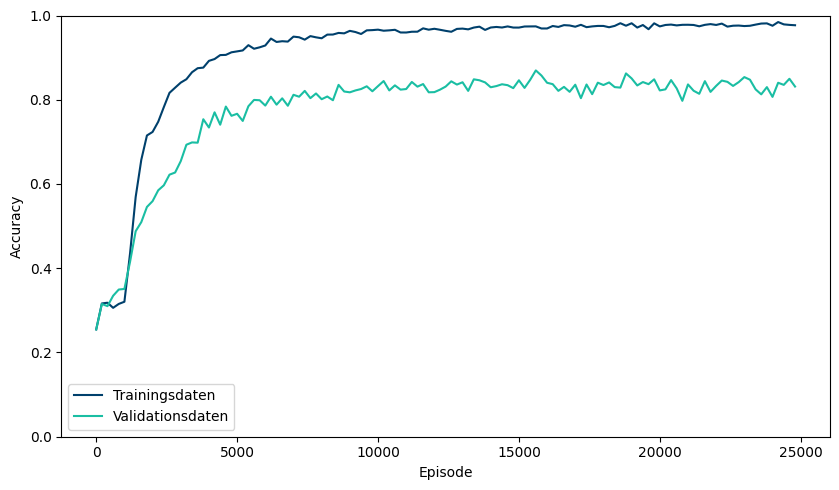

In [ ]:
plot_traincurve('training/run_0', ['train_accuracy', 'eval_accuracy'], 'Accuracy')

## Perform a tuning run

The most decisive hyperparameters present in the model are determined by a tuning process, which runs the model training several times and tries to boost the models performance by minimizing the evaluation-loss with adaptations to the hyperparameters. 

In [ ]:
tuning = optuna.create_study(direction="minimize", 
                             sampler = optuna.samplers.TPESampler(),
                             pruner = optuna.pruners.MedianPruner(n_startup_trials=5))

tuning.optimize(run_tuning, n_trials=25)

pruned_trials = tuning.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = tuning.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
importances = optuna.importance.get_param_importances(tuning)

print('\n')
print('#######################################################################')
print('########################### FINISHED TUNING ###########################')
print('#######################################################################')
print('\n \n')

print('Tuning statistics: ')
print('  Number of trials: ', len(tuning.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials), '\n')

print('Best trial:')
trial = tuning.best_trial

print(f'  Run {str(trial.number)} with Loss {min(trial.intermediate_values.values())} at Episode {min(trial.intermediate_values, key=trial.intermediate_values.get)}')

print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2022-06-02 07:19:00,480] A new study created in memory with name: no-name-2d561ca7-867f-42be-8290-d41b05c56101


Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_0

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 19.5s (25.66/s)                              
    Loss: 0.15907
    Accuracy: 0.25888
  Validation with 200 Evaluation-Episodes. Accuracy: 0.33388, Loss: 0.14954

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 19.3s (25.93/s)                              
    Loss: 0.14355
    Accuracy: 0.42680
  Validation with 200 Evaluation-Episodes. Accuracy: 0.46538, Loss: 0.13865

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 20.4s (24.53/s)                              
    Loss: 0.1

[I 2022-06-02 07:39:23,442] Trial 0 finished with value: 0.07794276512227953 and parameters: {'num_fc_layers': 3, 'num_units_fc_layer0': 256, 'num_units_fc_layer1': 128, 'num_units_fc_layer2': 128, 'num_lstm_layer_encoder': 1, 'num_units_lstm_encoder': 16, 'num_lstm_layer_relationnet': 3, 'num_units_lstm_relationnet': 32, 'learning_rate': 0.00043496554227764645, 'learning_rate_schedule_rate': 500}. Best is trial 0 with value: 0.07794276512227953.


  Validation with 200 Evaluation-Episodes. Accuracy: 0.82000, Loss: 0.08267

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_1

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 20.8s (23.99/s)                              
    Loss: 0.15989
    Accuracy: 0.22063
  Validation with 200 Evaluation-Episodes. Accuracy: 0.28663, Loss: 0.14748

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 20.9s (23.90/s)                              
    Loss: 0.15000
    Accuracy: 0.26648
  Validation with 200 Evaluation-Episodes. Accuracy: 0.30369, Loss: 0.14392

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████| 

[I 2022-06-02 08:00:55,665] Trial 1 finished with value: 0.08426999195478857 and parameters: {'num_fc_layers': 3, 'num_units_fc_layer0': 128, 'num_units_fc_layer1': 32, 'num_units_fc_layer2': 32, 'num_lstm_layer_encoder': 3, 'num_units_lstm_encoder': 32, 'num_lstm_layer_relationnet': 1, 'num_units_lstm_relationnet': 16, 'learning_rate': 0.001258455389876088, 'learning_rate_schedule_rate': 5500}. Best is trial 0 with value: 0.07794276512227953.


  Validation with 200 Evaluation-Episodes. Accuracy: 0.80037, Loss: 0.08427

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_2

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 20.9s (23.91/s)                              
    Loss: 0.17565
    Accuracy: 0.20040
  Validation with 200 Evaluation-Episodes. Accuracy: 0.20000, Loss: 0.16000

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 20.8s (24.09/s)                              
    Loss: 0.16000
    Accuracy: 0.20000
  Validation with 200 Evaluation-Episodes. Accuracy: 0.20000, Loss: 0.16000

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████| 

[I 2022-06-02 08:22:22,399] Trial 2 finished with value: 0.09210757574066519 and parameters: {'num_fc_layers': 2, 'num_units_fc_layer0': 32, 'num_units_fc_layer1': 128, 'num_lstm_layer_encoder': 3, 'num_units_lstm_encoder': 64, 'num_lstm_layer_relationnet': 1, 'num_units_lstm_relationnet': 16, 'learning_rate': 0.0001927966490719631, 'learning_rate_schedule_rate': 6000}. Best is trial 0 with value: 0.07794276512227953.


  Validation with 200 Evaluation-Episodes. Accuracy: 0.77731, Loss: 0.09246

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_3

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 33.0s (15.14/s)                              
    Loss: 0.18763
    Accuracy: 0.20005
  Validation with 200 Evaluation-Episodes. Accuracy: 0.20019, Loss: 0.15992

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 32.2s (15.53/s)                              
    Loss: 0.15987
    Accuracy: 0.20023
  Validation with 200 Evaluation-Episodes. Accuracy: 0.20663, Loss: 0.15917

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████| 

[I 2022-06-02 08:55:50,066] Trial 3 finished with value: 0.14126560240983962 and parameters: {'num_fc_layers': 1, 'num_units_fc_layer0': 128, 'num_lstm_layer_encoder': 3, 'num_units_lstm_encoder': 32, 'num_lstm_layer_relationnet': 2, 'num_units_lstm_relationnet': 256, 'learning_rate': 1.7048378102119872e-05, 'learning_rate_schedule_rate': 6500}. Best is trial 0 with value: 0.07794276512227953.


  Validation with 200 Evaluation-Episodes. Accuracy: 0.33581, Loss: 0.14324

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_4

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 17.4s (28.81/s)                              
    Loss: 0.17536
    Accuracy: 0.20418
  Validation with 200 Evaluation-Episodes. Accuracy: 0.21756, Loss: 0.15784

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 17.7s (28.23/s)                              
    Loss: 0.15506
    Accuracy: 0.26873
  Validation with 200 Evaluation-Episodes. Accuracy: 0.31006, Loss: 0.14840

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████| 

[I 2022-06-02 09:14:51,822] Trial 4 finished with value: 0.09423225566744804 and parameters: {'num_fc_layers': 1, 'num_units_fc_layer0': 128, 'num_lstm_layer_encoder': 1, 'num_units_lstm_encoder': 32, 'num_lstm_layer_relationnet': 1, 'num_units_lstm_relationnet': 128, 'learning_rate': 4.092084931449769e-05, 'learning_rate_schedule_rate': 4500}. Best is trial 0 with value: 0.07794276512227953.


  Validation with 200 Evaluation-Episodes. Accuracy: 0.74463, Loss: 0.09887

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_5

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 17.5s (28.54/s)                              
    Loss: 0.17504
    Accuracy: 0.19955


[I 2022-06-02 09:15:14,277] Trial 5 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20400, Loss: 0.15940

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_6

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 19.1s (26.12/s)                              
    Loss: 0.24061
    Accuracy: 0.19970


[I 2022-06-02 09:15:38,112] Trial 6 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.19788, Loss: 0.23307

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_7

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 19.3s (25.87/s)                              
    Loss: 0.24109
    Accuracy: 0.20070


[I 2022-06-02 09:16:02,268] Trial 7 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20206, Loss: 0.22297

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_8

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 30.7s (16.29/s)                              
    Loss: 0.16193
    Accuracy: 0.19983


[I 2022-06-02 09:16:40,244] Trial 8 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20006, Loss: 0.16000

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_9

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 21.8s (22.94/s)                              
    Loss: 0.19123
    Accuracy: 0.20038


[I 2022-06-02 09:17:07,080] Trial 9 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20269, Loss: 0.15977

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_10

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 26.5s (18.90/s)                              
    Loss: 0.16069
    Accuracy: 0.20118


[I 2022-06-02 09:17:39,716] Trial 10 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.19975, Loss: 0.16000

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_11

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 24.6s (20.31/s)                              
    Loss: 0.15522
    Accuracy: 0.28533
  Validation with 200 Evaluation-Episodes. Accuracy: 0.33419, Loss: 0.14363

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 25.1s (19.93/s)                              
    Loss: 0.14876
    Accuracy: 0.30437
  Validation with 200 Evaluation-Episodes. Accuracy: 0.30975, Loss: 0.14757

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████|

[I 2022-06-02 09:20:44,152] Trial 11 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.32056, Loss: 0.14651

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_12

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 24.4s (20.46/s)                              
    Loss: 0.16131
    Accuracy: 0.20003


[I 2022-06-02 09:21:14,092] Trial 12 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20000, Loss: 0.16000

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_13

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 33.4s (14.98/s)                              
    Loss: 0.16906
    Accuracy: 0.19955


[I 2022-06-02 09:21:55,038] Trial 13 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20394, Loss: 0.16000

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_14

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 23.1s (21.68/s)                              
    Loss: 0.15852
    Accuracy: 0.25745


[I 2022-06-02 09:22:23,739] Trial 14 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20375, Loss: 0.15997

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_15

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 18.5s (27.01/s)                              
    Loss: 0.15445
    Accuracy: 0.28990
  Validation with 200 Evaluation-Episodes. Accuracy: 0.32531, Loss: 0.14535

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 18.3s (27.34/s)                              
    Loss: 0.14984
    Accuracy: 0.33113
  Validation with 200 Evaluation-Episodes. Accuracy: 0.35044, Loss: 0.14577

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████|

[I 2022-06-02 09:23:58,004] Trial 15 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.45819, Loss: 0.14954

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_16

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 24.4s (20.48/s)                              
    Loss: 0.17011
    Accuracy: 0.20050


[I 2022-06-02 09:24:27,634] Trial 16 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20031, Loss: 0.16000

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_17

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 21.4s (23.40/s)                              
    Loss: 0.15787
    Accuracy: 0.24648
  Validation with 200 Evaluation-Episodes. Accuracy: 0.32119, Loss: 0.14454

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 21.4s (23.37/s)                              
    Loss: 0.14928
    Accuracy: 0.29800
  Validation with 200 Evaluation-Episodes. Accuracy: 0.32619, Loss: 0.14376

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████|

[I 2022-06-02 09:34:40,030] Trial 17 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.65156, Loss: 0.11504

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_18

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 25.1s (19.94/s)                              
    Loss: 0.16163
    Accuracy: 0.19885


[I 2022-06-02 09:35:11,266] Trial 18 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.19969, Loss: 0.16000

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_19

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 21.5s (23.27/s)                              
    Loss: 0.15869
    Accuracy: 0.25533
  Validation with 200 Evaluation-Episodes. Accuracy: 0.32544, Loss: 0.14627

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 21.7s (23.02/s)                              
    Loss: 0.14851
    Accuracy: 0.31910
  Validation with 200 Evaluation-Episodes. Accuracy: 0.33981, Loss: 0.14390

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████|

[I 2022-06-02 09:58:37,469] Trial 19 finished with value: 0.0695009343791753 and parameters: {'num_fc_layers': 2, 'num_units_fc_layer0': 32, 'num_units_fc_layer1': 128, 'num_lstm_layer_encoder': 1, 'num_units_lstm_encoder': 64, 'num_lstm_layer_relationnet': 1, 'num_units_lstm_relationnet': 256, 'learning_rate': 0.0004965609734577599, 'learning_rate_schedule_rate': 8000}. Best is trial 19 with value: 0.0695009343791753.


  Validation with 200 Evaluation-Episodes. Accuracy: 0.85806, Loss: 0.07208

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_20

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 46.2s (10.83/s)                              
    Loss: 0.16210
    Accuracy: 0.20003


[I 2022-06-02 09:59:32,666] Trial 20 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.20025, Loss: 0.16000

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_21

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 22.0s (22.77/s)                              
    Loss: 0.15985
    Accuracy: 0.26483
  Validation with 200 Evaluation-Episodes. Accuracy: 0.33275, Loss: 0.14734

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 22.0s (22.73/s)                              
    Loss: 0.14799
    Accuracy: 0.36307
  Validation with 200 Evaluation-Episodes. Accuracy: 0.37169, Loss: 0.14550

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████|

[I 2022-06-02 10:23:04,158] Trial 21 finished with value: 0.07037286577746273 and parameters: {'num_fc_layers': 2, 'num_units_fc_layer0': 32, 'num_units_fc_layer1': 128, 'num_lstm_layer_encoder': 1, 'num_units_lstm_encoder': 64, 'num_lstm_layer_relationnet': 1, 'num_units_lstm_relationnet': 256, 'learning_rate': 0.00013262311068753025, 'learning_rate_schedule_rate': 7000}. Best is trial 19 with value: 0.0695009343791753.


  Validation with 200 Evaluation-Episodes. Accuracy: 0.82287, Loss: 0.07887

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_22

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 22.0s (22.75/s)                              
    Loss: 0.16480
    Accuracy: 0.22880


[I 2022-06-02 10:23:32,275] Trial 22 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.29425, Loss: 0.15121

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_23

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 22.1s (22.60/s)                              
    Loss: 0.15751
    Accuracy: 0.29263
  Validation with 200 Evaluation-Episodes. Accuracy: 0.35962, Loss: 0.14661

Episode: 500/25000 to 1000/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 22.0s (22.77/s)                              
    Loss: 0.13839
    Accuracy: 0.46442
  Validation with 200 Evaluation-Episodes. Accuracy: 0.44519, Loss: 0.14234

Episode: 1000/25000 to 1500/25000
  Training... |████████████████████████████████████████|

[I 2022-06-02 10:47:15,426] Trial 23 finished with value: 0.0732845501601696 and parameters: {'num_fc_layers': 2, 'num_units_fc_layer0': 32, 'num_units_fc_layer1': 128, 'num_lstm_layer_encoder': 1, 'num_units_lstm_encoder': 64, 'num_lstm_layer_relationnet': 1, 'num_units_lstm_relationnet': 256, 'learning_rate': 0.00016570627767703748, 'learning_rate_schedule_rate': 8000}. Best is trial 19 with value: 0.0695009343791753.


  Validation with 200 Evaluation-Episodes. Accuracy: 0.82619, Loss: 0.07750

Initializing training...

  Parameters accepted and set.
  Feature encoder intialized, initial weights set.
  Relation network intialized, initial weights set.
  Optimizer & Learning Rate Scheduler initalized.
  Created logging folder: tuning/run_24

Training initalized. 


Start training...

Episode: 0/25000 to 500/25000
  Training... |████████████████████████████████████████| 500/500 [100%] in 22.1s (22.66/s)                              
    Loss: 0.16218
    Accuracy: 0.23480


[I 2022-06-02 10:47:43,513] Trial 24 pruned. 


  Validation with 200 Evaluation-Episodes. Accuracy: 0.27956, Loss: 0.14988



#######################################################################
########################### FINISHED TUNING ###########################
#######################################################################

 

Tuning statistics: 
  Number of trials:  25
  Number of pruned trials:  17
  Number of complete trials:  8 

Best trial:
  Run 19 with Loss 0.0695009343791753 at Episode 20500
  Params: 
    num_fc_layers: 2
    num_units_fc_layer0: 32
    num_units_fc_layer1: 128
    num_lstm_layer_encoder: 1
    num_units_lstm_encoder: 64
    num_lstm_layer_relationnet: 1
    num_units_lstm_relationnet: 256
    learning_rate: 0.0004965609734577599
    learning_rate_schedule_rate: 8000


Zip and push tuning results to Google Drive.

In [ ]:
push_zip('/content/tuning', gdrive + f'/results/tuning/{N_WAY}way-{K_SHOT}shot.zip')

with open(gdrive + f'/results/tuning/importances_{N_WAY}way-{K_SHOT}shot.pkl', 'wb') as handle:
    pickle.dump(importances, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analyze the tuning run

Load and unpack tuning results from Google Drive.

In [ ]:
os.system(f'cp -R /content/drive/MyDrive/ml_projects/STRHANGE/results/tuning/{N_WAY}way-{K_SHOT}shot.zip /content')
shutil.unpack_archive(f'{N_WAY}way-{K_SHOT}shot.zip', '/content')

with open(gdrive + f'/results/tuning/importances_{N_WAY}way-{K_SHOT}shot.pkl', 'rb') as handle:
  importances = pickle.load(handle)

Success of the tuning process is examined by analyzing the best values in each run and the training curves.

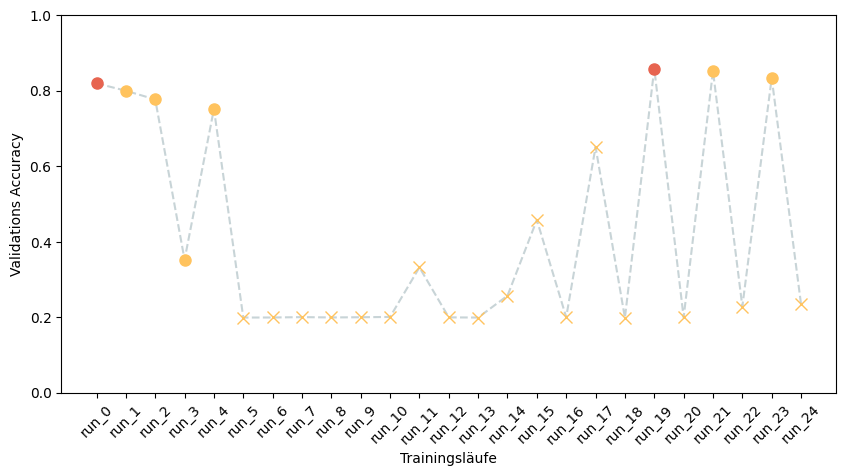

In [ ]:
plot_tuning_history('tuning', 'eval_accuracy', 'Validations Accuracy', 'maximize')

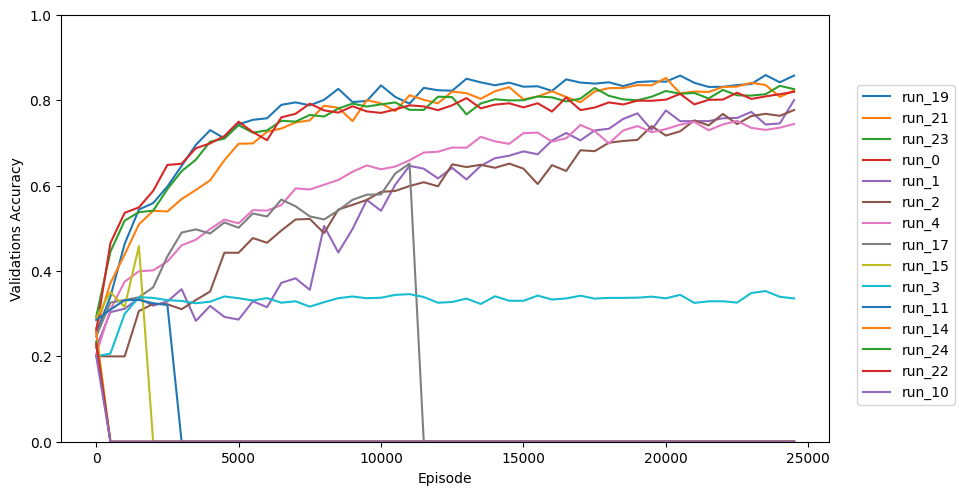

In [ ]:
plot_tuning_traincurves('tuning', 'eval_accuracy', 'Validations Accuracy', 'maximize', 15)

In [ ]:
best_trials = tuning.trials_dataframe().nsmallest(5, 'value').transpose().drop(['number', 'datetime_start', 'datetime_complete'])

print(tabulate(best_trials, tablefmt = 'latex', headers=best_trials.columns, numalign="right", floatfmt=".2f"))

\begin{tabular}{llllll}
\hline
                                    & 19                     & 21                     & 23                     & 0                      & 1                      \\
\hline
 value                              & 0.0695009343791753     & 0.07037286577746273    & 0.0732845501601696     & 0.07794276512227953    & 0.08426999195478857    \\
 duration                           & 0 days 00:23:26.201386 & 0 days 00:23:31.489956 & 0 days 00:23:43.147119 & 0 days 00:20:22.960202 & 0 days 00:21:32.220271 \\
 params\_learning\_rate               & 0.0004965609734577599  & 0.00013262311068753025 & 0.00016570627767703748 & 0.00043496554227764645 & 0.001258455389876088   \\
 params\_learning\_rate\_schedule\_rate & 8000                   & 7000                   & 8000                   & 500                    & 5500                   \\
 params\_num\_fc\_layers               & 2                      & 2                      & 2                      & 3                   

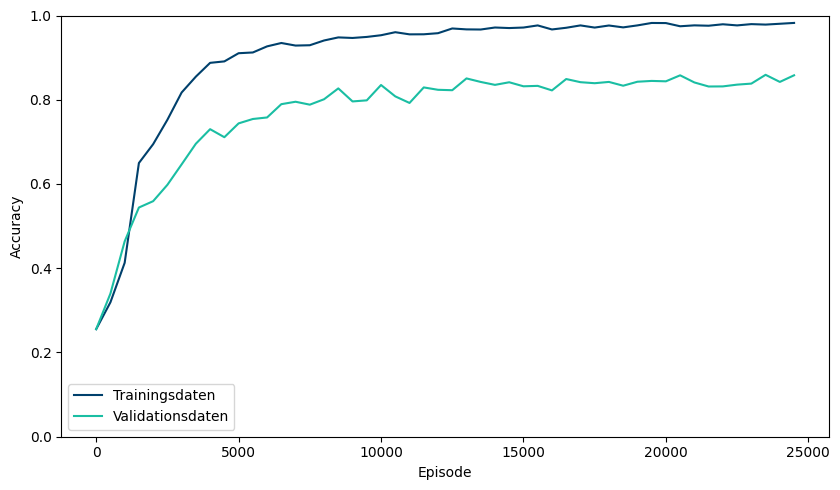

In [ ]:
plot_traincurve('tuning/run_19', ['train_accuracy', 'eval_accuracy'], 'Accuracy')

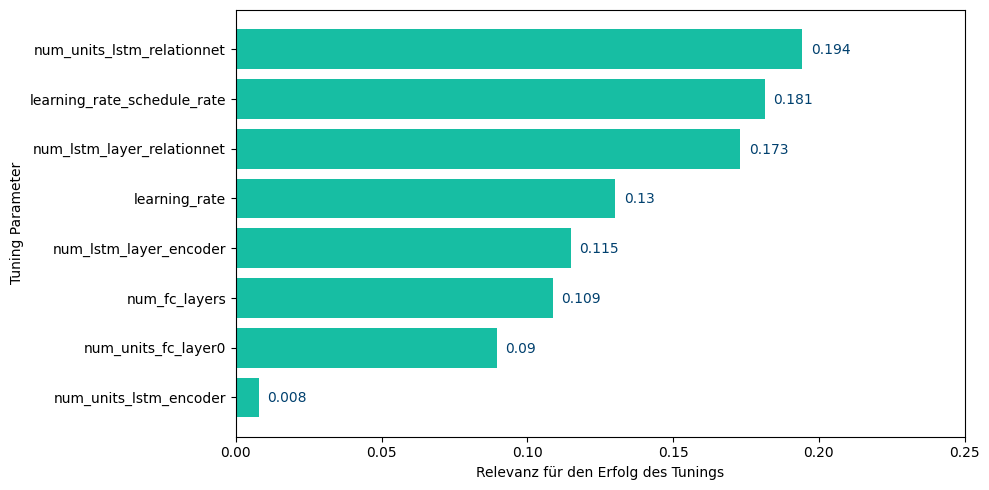

In [ ]:
plot_tuning_parameter_importance(importances)

## Model selection

Select the final model (run an episode to stop) on the basis of the tuning analyses. 

In [ ]:
selected_run = 'run_19'
selected_episode = '13000'

# Model evaluation

Evaluate the model on unseen data.

In [ ]:
conf_matrix, classification_report, accuracy = run_testing(num_testruns = 1000, samples_per_run = 32, run_dir = f'tuning/{selected_run}', episode = f'e{selected_episode}', test_classes = test_classes)

In [ ]:
model_name = f'{N_WAY}-way_{K_SHOT}-sup'
path = os.path.join(gdrive, 'results', 'tests')

np.save(os.path.join(path, f'{model_name}_CM.npy'), conf_matrix)
classification_report.to_pickle(os.path.join(path, f'{model_name}_CR.pkl'))
np.save(os.path.join(path, f'{model_name}_ACC.npy'), accuracy)

Visualize Confusion Matrix

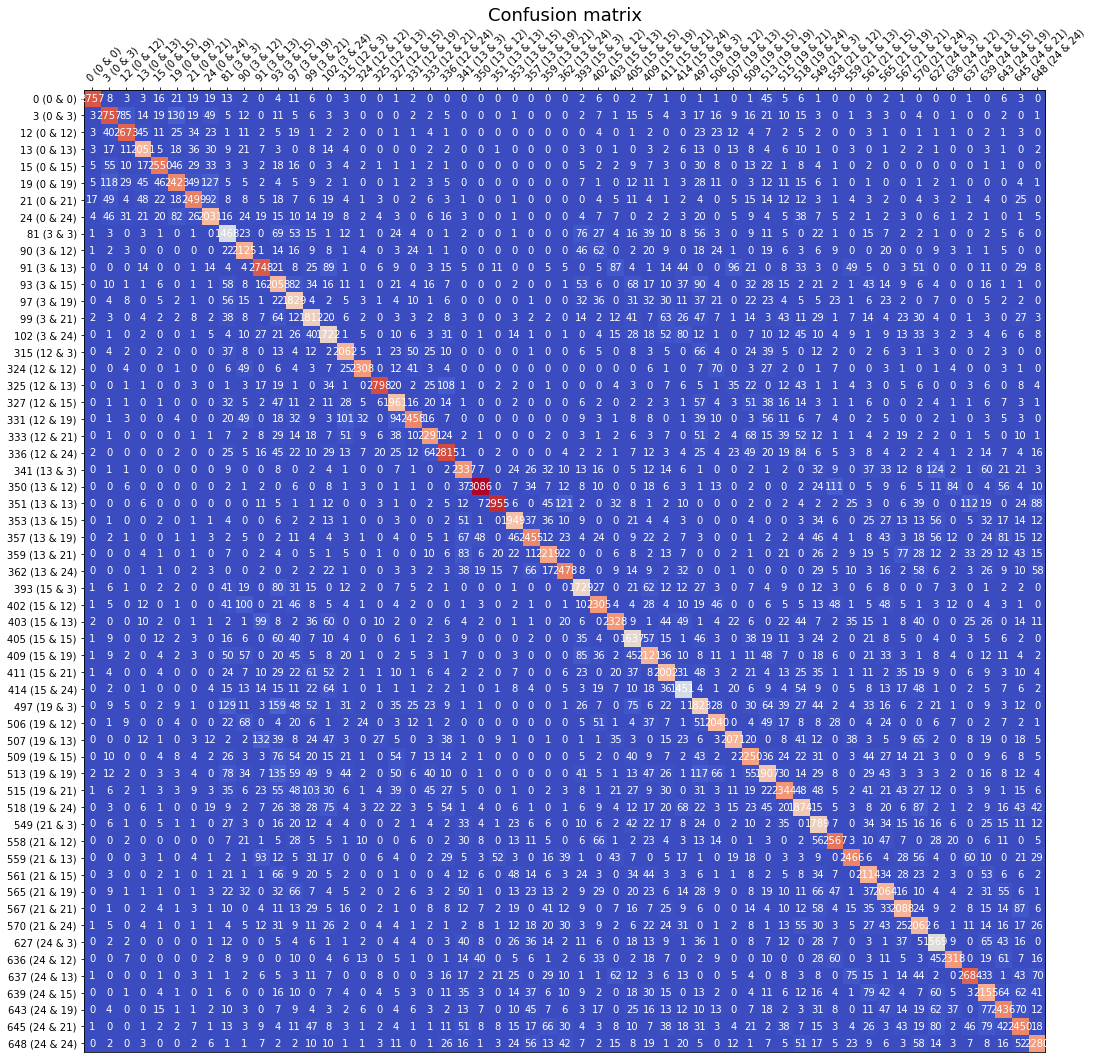

In [ ]:
plot_conf_matrix (conf_matrix, test_classes, y_og)

Analyse Accuracy, Precision, Recall and F-Score.

In [ ]:
print(f'Average Accuracy of the model on testdata {accuracy}\n')
print(f'Average Precision of the model on testdata {round(classification_report.Precision.mean(),3)}\n') 
print(f'Average Recall of the model on testdata {round(classification_report.Recall.mean() ,3)}\n') 
print(f'Average F-Score of the model on testdata {round(classification_report.FScore.mean() ,3)}\n') 

print(tabulate(classification_report, tablefmt = 'latex', headers=classification_report.columns, numalign="right", floatfmt=".2f"))

Average Accuracy of the model on testdata 0.8403

Average Precision of the model on testdata 0.839

Average Recall of the model on testdata 0.839

Average F-Score of the model on testdata 0.839

\begin{tabular}{lrrr}
\hline
               &   Precision &   Recall &   FScore \\
\hline
 0 (0 \& 0)     &        0.96 &     0.98 &     0.94 \\
 3 (0 \& 3)     &        0.87 &     0.85 &     0.86 \\
 12 (0 \& 12)   &        0.93 &     0.98 &     0.95 \\
 13 (0 \& 13)   &        0.90 &     0.92 &     0.91 \\
 15 (0 \& 15)   &        0.94 &     0.95 &     0.97 \\
 19 (0 \& 19)   &        0.86 &     0.90 &     0.88 \\
 21 (0 \& 21)   &        0.87 &     0.96 &     0.91 \\
 24 (0 \& 24)   &        0.88 &     0.91 &     0.89 \\
 81 (3 \& 3)    &        0.81 &     0.67 &     0.73 \\
 90 (3 \& 12)   &        0.91 &     0.84 &     0.87 \\
 91 (3 \& 13)   &        0.84 &     0.89 &     0.86 \\
 93 (3 \& 15)   &        0.77 &     0.65 &     0.71 \\
 97 (3 \& 19)   &        0.80 &     0.66 &     0.72 \\


Test the model on origial Jester-Data.

In [ ]:
conf_matrix, classification_report, accuracy = run_testing(num_testruns = 500, samples_per_run = 32, run_dir = f'tuning/{selected_run}', episode = f'e{selected_episode}', test_classes = jester_comp_classes, split = 'jester')

In [ ]:
print(f'Average Accuracy of the model on Jester: {accuracy}\n')

Average Accuracy of the model on Jester: 0.8927875



# Model saving

Save the best model to the Google Drive.

In [ ]:
push_model_to_gdrive(f'tuning/{selected_run}', f'e{selected_episode}',f'{N_WAY}way-{K_SHOT}shot')